In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from riskyneuroarousal.utils.load_data import (load_behavioral_data, load_pupil_data)
from scipy.stats import false_discovery_control
%load_ext rpy2.ipython

Now, lets look at if pupil size is responding to how much bigger losses are than equivalent gains

In [2]:
behavior = load_behavioral_data(min_RT = 0.2)
pupil_data = load_pupil_data()
data = pupil_data.merge(behavior, on=["sub", "trial"])
data["pupil_size"] = data["ps_preprocessed"] - data["baseline"]

In [3]:
data["loss_gain"] = np.log(data["loss"] / data["gain"])

In [4]:
%%R -i data
library(mgcv)
library(lme4)
library(lmerTest)
library(broom.mixed)

Loading required package: nlme
This is mgcv 1.9-1. For overview type 'help("mgcv-package")'.
Loading required package: Matrix

Attaching package: ‘lme4’

The following object is masked from ‘package:nlme’:

    lmList


Attaching package: ‘lmerTest’

The following object is masked from ‘package:lme4’:

    lmer

The following object is masked from ‘package:stats’:

    step



First, we examine if there are differences in the interaction between stimuli and pupil size. 

In [25]:
%%R -o results
# loop through timebins
results <- data.frame()
for (tb in unique(data$timebin)) {
    # for each timebin, run a linear mixed effects model of ps_preprocessed
    model = lmer(pupil_size ~ poly(loss_gain, 2)*condition + RT*condition + blink*condition + (1| sub) + (-1 + RT|sub) + (-1 + blink | sub) + (-1 + loss_gain|sub), data=data[data$timebin == tb, ])
    # Gather results
    model_result <- tidy(model, effects = "fixed", conf.int = TRUE, conf.level = 0.95) 
    model_result$timebin <- tb
    # Append results
    results <- rbind(results, model_result)
}

boundary (singular) fit: see help('isSingular')
In addition: Warning messages:
1: In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv,  :
  Model failed to converge with max|grad| = 0.00658915 (tol = 0.002, component 1)
2: In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv,  :
  Model failed to converge with max|grad| = 0.00568536 (tol = 0.002, component 1)


In [29]:
results["p.value"] = false_discovery_control(results["p.value"], method = "by")
results = results.rename(columns={"p.value": "p_value"})

KeyError: 'p.value'

In [27]:
# From this, all I want to look is at the pvalues that are significant
results = results.query("p_value < 0.05 & term.str.contains('conditionequalRange')")

In [31]:
results

,effect,term,estimate,std.error,statistic,df,p_value,conf.low,conf.high,timebin
77,fixed,"poly(loss_gain, 2)1:conditionequalRange",-12.216891,3.641571,-3.354841,119.786559,2.299075e-02,-19.427079,-5.006703,0.903226
87,fixed,"poly(loss_gain, 2)1:conditionequalRange",-16.873146,3.880221,-4.348502,114.250979,7.321546e-04,-24.559651,-9.186640,1.032258
97,fixed,"poly(loss_gain, 2)1:conditionequalRange",-22.704337,4.137264,-5.487766,108.993522,7.758568e-06,-30.904265,-14.504408,1.161290
107,fixed,"poly(loss_gain, 2)1:conditionequalRange",-29.303140,4.329863,-6.767683,107.197788,3.113691e-08,-37.886407,-20.719873,1.290323
117,fixed,"poly(loss_gain, 2)1:conditionequalRange",-33.986069,4.488745,-7.571397,106.311661,8.734518e-10,-42.885142,-25.086997,1.419355
127,fixed,"poly(loss_gain, 2)1:conditionequalRange",-37.385331,4.726761,-7.909291,101.075812,3.598007e-10,-46.761868,-28.008793,1.548387
137,fixed,"poly(loss_gain, 2)1:conditionequalRange",-40.000849,4.949977,-8.081018,96.729509,3.103496e-10,-49.825530,-30.176169,1.677419
147,fixed,"poly(loss_gain, 2)1:conditionequalRange",-41.699803,5.193084,-8.029872,92.758081,3.374896e-10,-52.012593,-31.387012,1.806452
157,fixed,"poly(loss_gain, 2)1:conditionequalRange",-43.908071,5.622171,-7.809807,85.925442,8.166028e-10,-55.084716,-32.731427,1.935484
167,fixed,"poly(loss_gain, 2)1:conditionequalRange",-46.422935,5.897308,-7.871886,83.120987,7.602976e-10,-58.152190,-34.693679,2.064516


In [32]:
%%R -o results_individual
# loop through timebins
results_individual <- data.frame()
for (tb in unique(data$timebin)) {
    # for each timebin, run a linear mixed effects model of ps_preprocessed
    modelIndifference = lmer(pupil_size ~ poly(loss_gain, 2) + RT + blink + (1| sub) + (-1 + RT|sub) + (-1 + blink | sub) + (-1 + loss_gain | sub), data=data[data$timebin == tb & data$condition == 'equalIndifference', ])
    modelRange = lmer(pupil_size ~ poly(loss_gain, 2) + blink + RT + (1| sub) + (-1 + RT|sub) + (-1 + blink | sub) + (-1 + loss_gain | sub), data=data[data$timebin == tb & data$condition == 'equalRange', ])
    # Gather results
    resultsIndifference <- tidy(modelIndifference, effects = "fixed", conf.int = TRUE, conf.level = 0.95) 
    resultsRange <- tidy(modelRange, effects = "fixed", conf.int = TRUE, conf.level = 0.95)
    resultsIndifference$condition <- 'equalIndifference'
    resultsRange$condition <- 'equalRange'
    resultsIndifference$timebin <- tb
    resultsRange$timebin <- tb
    # Append results
    results_individual <- rbind(results_individual, resultsIndifference)
    results_individual <- rbind(results_individual, resultsRange)
}

boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
In addition: Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv,  :
  Model failed to converge with max|grad| = 0.00686687 (tol = 0.002, component 1)


In [33]:
results_individual["p.value"] = false_discovery_control(results_individual["p.value"], method = "by")
results_individual = results_individual.rename(columns={"p.value": "p_value"})

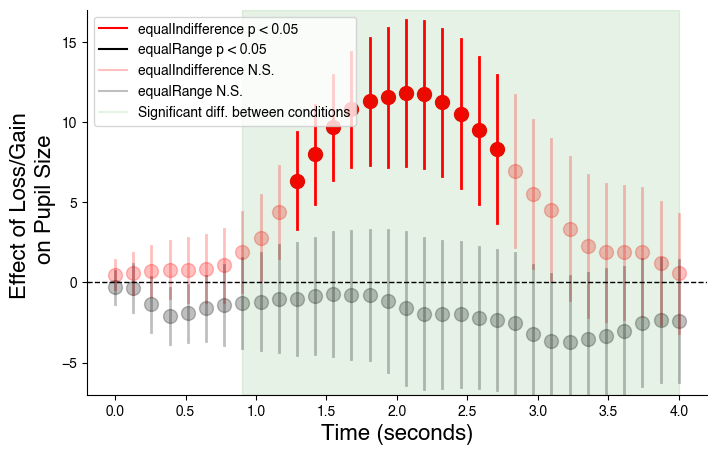

In [34]:
plt.rcParams["font.family"] = "Helvetica"
fig, ax = plt.subplots(figsize=(8, 5))
grouped_df = results_individual.query("term == 'poly(loss_gain, 2)1'").sort_values(["timebin", "condition"]).reset_index(drop=True)

# For each timebin, plot the estimate of the gain effect for each condition. If the pvalue is not significant, alpha = 0.25
for i, row in grouped_df.iterrows():
    if row["p_value"] < 0.05:
        alpha = 1
    else:
        alpha = 0.25
    if row["condition"] == "equalIndifference":
        color = "red"
    elif row["condition"] == "equalRange":
        color = "black"
    ax.plot([row["timebin"], row["timebin"]], [row["conf.low"], row["conf.high"]], color=color, linewidth=2, alpha=alpha)
    ax.scatter(row["timebin"], row["estimate"], color=color, s=100, alpha=alpha)

ax.plot([], [], color = "red", alpha = 1, label="equalIndifference p < 0.05")
ax.plot([], [], color = "black", label="equalRange p < 0.05")
ax.plot([], [], color = "red", alpha = 0.25, label="equalIndifference N.S.")
ax.plot([], [], color = "black", alpha = 0.25, label="equalRange N.S.")
ax.plot([], [], color = "green", alpha = 0.1, label="Significant diff. between conditions")
ax.set_xlabel("Time (seconds)", fontsize=16)
ax.set_ylabel("Effect of Loss/Gain \n on Pupil Size", fontsize=16)
# Remove top and right spines
sns.despine(ax=ax, top=True, right=True)
# Add horizontal line at y=0
ax.axhline(0, color="black", linestyle="--", linewidth=1)
# Add legend where red is equalIndifference and black is equalRange
plt.legend()
if linear_term.shape[0] > 0:
    ax.axvspan(min(linear_term), max(linear_term), color="green", alpha=0.1)
ax.set_ylim(-7, 17)
plt.show()

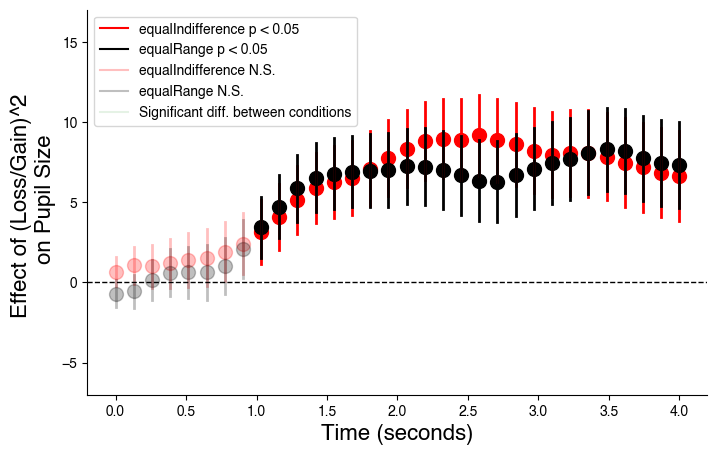

In [12]:
plt.rcParams["font.family"] = "Helvetica"
fig, ax = plt.subplots(figsize=(8, 5))
grouped_df = results_individual.query("term == 'poly(loss_gain, 2)2'").sort_values(["timebin", "condition"]).reset_index(drop=True)

# For each timebin, plot the estimate of the gain effect for each condition. If the pvalue is not significant, alpha = 0.25
for i, row in grouped_df.iterrows():
    if row["p_value"] < 0.05:
        alpha = 1
    else:
        alpha = 0.25
    if row["condition"] == "equalIndifference":
        color = "red"
    elif row["condition"] == "equalRange":
        color = "black"
    ax.plot([row["timebin"], row["timebin"]], [row["conf.low"], row["conf.high"]], color=color, linewidth=2, alpha=alpha)
    ax.scatter(row["timebin"], row["estimate"], color=color, s=100, alpha=alpha)

ax.plot([], [], color = "red", alpha = 1, label="equalIndifference p < 0.05")
ax.plot([], [], color = "black", label="equalRange p < 0.05")
ax.plot([], [], color = "red", alpha = 0.25, label="equalIndifference N.S.")
ax.plot([], [], color = "black", alpha = 0.25, label="equalRange N.S.")
ax.plot([], [], color = "green", alpha = 0.1, label="Significant diff. between conditions")

ax.set_xlabel("Time (seconds)", fontsize=16)
ax.set_ylabel("Effect of (Loss/Gain)^2 \n on Pupil Size", fontsize=16)
# Remove top and right spines
sns.despine(ax=ax, top=True, right=True)
# Add horizontal line at y=0
ax.axhline(0, color="black", linestyle="--", linewidth=1)
# Add legend where red is equalIndifference and black is equalRange
plt.legend()
# if loss_gain_timebin.shape[0] > 0:
#     ax.axvspan(min(loss_gain_timebin), max(loss_gain_timebin), color="red", alpha=0.1)
ax.set_ylim(-7, 17)
plt.show()

In [13]:
results_individual

,effect,term,estimate,std.error,statistic,df,p_value,conf.low,conf.high,condition,timebin
1,fixed,(Intercept),-0.006397,0.017402,-0.367608,263.035587,1.000000e+00,-0.040662,0.027868,equalIndifference,0.0
2,fixed,"poly(loss_gain, 2)1",0.473038,0.458739,1.031170,7099.701175,1.000000e+00,-0.426228,1.372303,equalIndifference,0.0
3,fixed,"poly(loss_gain, 2)2",0.661908,0.463615,1.427711,7028.755715,1.000000e+00,-0.246917,1.570733,equalIndifference,0.0
4,fixed,RT,-0.006516,0.009599,-0.678805,694.670843,1.000000e+00,-0.025362,0.012330,equalIndifference,0.0
5,fixed,blink,0.051620,0.024253,2.128363,23.611008,5.759015e-01,0.001520,0.101720,equalIndifference,0.0
...,...,...,...,...,...,...,...,...,...,...,...
316,fixed,(Intercept),-0.686095,0.064598,-10.620996,89.014237,2.441993e-15,-0.814450,-0.557741,equalRange,4.0
317,fixed,"poly(loss_gain, 2)1",-2.421696,1.852718,-1.307105,26.072510,1.000000e+00,-6.229496,1.386105,equalRange,4.0
318,fixed,"poly(loss_gain, 2)2",7.316820,1.373248,5.328113,6841.303478,3.301464e-06,4.624827,10.008812,equalRange,4.0
319,fixed,blink,0.187172,0.059898,3.124845,20.122998,8.764387e-02,0.062276,0.312068,equalRange,4.0


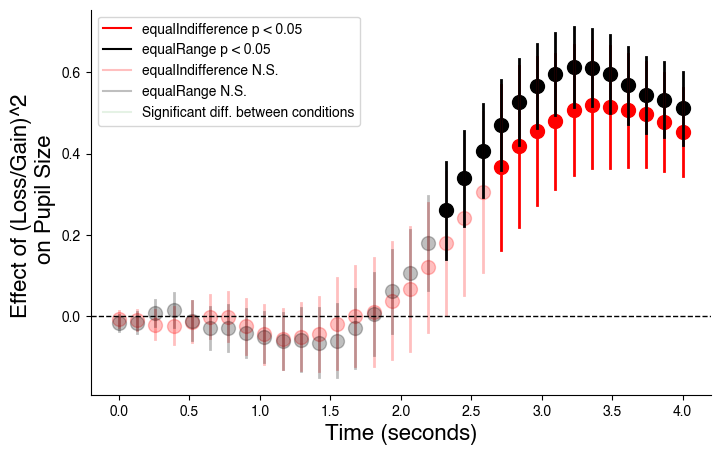

In [15]:
plt.rcParams["font.family"] = "Helvetica"
fig, ax = plt.subplots(figsize=(8, 5))
grouped_df = results_individual.query("term == 'RT'").sort_values(["timebin", "condition"]).reset_index(drop=True)

# For each timebin, plot the estimate of the gain effect for each condition. If the pvalue is not significant, alpha = 0.25
for i, row in grouped_df.iterrows():
    if row["p_value"] < 0.05:
        alpha = 1
    else:
        alpha = 0.25
    if row["condition"] == "equalIndifference":
        color = "red"
    elif row["condition"] == "equalRange":
        color = "black"
    ax.plot([row["timebin"], row["timebin"]], [row["conf.low"], row["conf.high"]], color=color, linewidth=2, alpha=alpha)
    ax.scatter(row["timebin"], row["estimate"], color=color, s=100, alpha=alpha)

ax.plot([], [], color = "red", alpha = 1, label="equalIndifference p < 0.05")
ax.plot([], [], color = "black", label="equalRange p < 0.05")
ax.plot([], [], color = "red", alpha = 0.25, label="equalIndifference N.S.")
ax.plot([], [], color = "black", alpha = 0.25, label="equalRange N.S.")
ax.plot([], [], color = "green", alpha = 0.1, label="Significant diff. between conditions")

ax.set_xlabel("Time (seconds)", fontsize=16)
ax.set_ylabel("Effect of (Loss/Gain)^2 \n on Pupil Size", fontsize=16)
# Remove top and right spines
sns.despine(ax=ax, top=True, right=True)
# Add horizontal line at y=0
ax.axhline(0, color="black", linestyle="--", linewidth=1)
# Add legend where red is equalIndifference and black is equalRange
plt.legend()
# if loss_gain_timebin.shape[0] > 0:
#     ax.axvspan(min(loss_gain_timebin), max(loss_gain_timebin), color="red", alpha=0.1)
# ax.set_ylim(-7, 17)
plt.show()